In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tqdm
import re
import librosa
from imblearn.combine import *
from sklearn import preprocessing
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from sklearn import linear_model
import scipy
from util import convertEMF
import pywt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, palette=palette)  # 解决Seaborn中文显示问题

In [40]:
df = pd.read_csv('../数据/population.csv')
df

,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
0,Afghanistan,1950,7480464,301735.0,1248282,3068855,4494349,4198587,4411609,3946595,...,757113,1241348,909953,661807,467170,271905,92691,9499,123,0.0
1,Afghanistan,1951,7571542,299368.0,1246857,3105444,4552138,4250002,4466098,3993640,...,768616,1260904,922765,667015,468881,273286,94358,10155,118,0.0
2,Afghanistan,1952,7667534,305393.0,1248220,3145070,4613604,4303436,4522464,4041439,...,781411,1280288,935638,672491,470898,274852,96026,10721,139,0.0
3,Afghanistan,1953,7764549,311574.0,1254725,3186382,4676232,4356242,4578167,4088379,...,794308,1298803,948321,678064,472969,276577,97705,11254,166,0.0
4,Afghanistan,1954,7864289,317584.0,1267817,3231060,4741371,4408474,4633229,4136116,...,806216,1316768,961484,684153,475117,278210,99298,11793,190,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,Zimbabwe,2017,14751101,464521.0,2287404,6217928,9224369,8056253,8532951,7476399,...,1690993,2422873,2021973,1088878,570769,467775,200927,59789,8974,222.0
18068,Zimbabwe,2018,15052191,466524.0,2283576,6291632,9385132,8264833,8760331,7689502,...,1732035,2474502,2058928,1155537,585529,476214,208587,59700,9299,228.0
18069,Zimbabwe,2019,15354606,468844.0,2281740,6367398,9543409,8473475,8986973,7909270,...,1759205,2546398,2085636,1220993,606266,479827,218763,60339,9546,235.0
18070,Zimbabwe,2020,15669663,470340.0,2287105,6449021,9709135,8691594,9220402,8139472,...,1776240,2640150,2101852,1291333,631541,476507,231604,61546,9629,240.0


In [41]:
delList = pd.read_excel('../数据/Country分类.xlsx')['合计'].drop_duplicates().values
print('delList', len(delList), delList)
df = df[~df['Country name'].isin(delList)]
df

delList 19 ['Asia (UN)' 'High-income countries'
 'Land-locked developing countries (LLDC)' 'Least developed countries'
 'Less developed regions' 'Less developed regions, excluding China'
 'Less developed regions, excluding least developed countries'
 'Low-income countries' 'Lower-middle-income countries'
 'More developed regions' 'Small island developing states (SIDS)'
 'Upper-middle-income countries' 'Africa (UN)' 'World' nan 'Europe (UN)'
 'Latin America and the Caribbean (UN)' 'Northern America (UN)'
 'Oceania (UN)']


,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
0,Afghanistan,1950,7480464,301735.0,1248282,3068855,4494349,4198587,4411609,3946595,...,757113,1241348,909953,661807,467170,271905,92691,9499,123,0.0
1,Afghanistan,1951,7571542,299368.0,1246857,3105444,4552138,4250002,4466098,3993640,...,768616,1260904,922765,667015,468881,273286,94358,10155,118,0.0
2,Afghanistan,1952,7667534,305393.0,1248220,3145070,4613604,4303436,4522464,4041439,...,781411,1280288,935638,672491,470898,274852,96026,10721,139,0.0
3,Afghanistan,1953,7764549,311574.0,1254725,3186382,4676232,4356242,4578167,4088379,...,794308,1298803,948321,678064,472969,276577,97705,11254,166,0.0
4,Afghanistan,1954,7864289,317584.0,1267817,3231060,4741371,4408474,4633229,4136116,...,806216,1316768,961484,684153,475117,278210,99298,11793,190,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,Zimbabwe,2017,14751101,464521.0,2287404,6217928,9224369,8056253,8532951,7476399,...,1690993,2422873,2021973,1088878,570769,467775,200927,59789,8974,222.0
18068,Zimbabwe,2018,15052191,466524.0,2283576,6291632,9385132,8264833,8760331,7689502,...,1732035,2474502,2058928,1155537,585529,476214,208587,59700,9299,228.0
18069,Zimbabwe,2019,15354606,468844.0,2281740,6367398,9543409,8473475,8986973,7909270,...,1759205,2546398,2085636,1220993,606266,479827,218763,60339,9546,235.0
18070,Zimbabwe,2020,15669663,470340.0,2287105,6449021,9709135,8691594,9220402,8139472,...,1776240,2640150,2101852,1291333,631541,476507,231604,61546,9629,240.0


In [42]:
# 剔除表头
表头筛选 = pd.read_excel('表头筛选.xlsx')
df = df.drop(columns=表头筛选['筛选'].dropna().drop_duplicates().to_list())
df

,Country name,Year,Population,Population at age 1,Population aged 1 to 4 years,Population aged 5 to 9 years,Population aged 10 to 14 years,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
0,Afghanistan,1950,7480464,258652.02,946547.0,966210,854363,757113,1241348,909953,661807,467170,271905,92691,9499,123,0.0
1,Afghanistan,1951,7571542,254304.00,947489.0,991791,866796,768616,1260904,922765,667015,468881,273286,94358,10155,118,0.0
2,Afghanistan,1952,7667534,252906.00,942827.0,1017993,878857,781411,1280288,935638,672491,470898,274852,96026,10721,139,0.0
3,Afghanistan,1953,7764549,258717.02,943151.0,1039950,891707,794308,1298803,948321,678064,472969,276577,97705,11254,166,0.0
4,Afghanistan,1954,7864289,264765.00,950233.0,1055592,907651,806216,1316768,961484,684153,475117,278210,99298,11793,190,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,Zimbabwe,2017,14751101,457422.00,1822883.0,2090939,1839585,1690993,2422873,2021973,1088878,570769,467775,200927,59789,8974,222.0
18068,Zimbabwe,2018,15052191,457587.00,1817052.0,2156068,1851988,1732035,2474502,2058928,1155537,585529,476214,208587,59700,9299,228.0
18069,Zimbabwe,2019,15354606,459748.00,1812896.0,2203375,1882283,1759205,2546398,2085636,1220993,606266,479827,218763,60339,9546,235.0
18070,Zimbabwe,2020,15669663,462625.00,1816765.0,2229093,1932823,1776240,2640150,2101852,1291333,631541,476507,231604,61546,9629,240.0


In [43]:
# 替换表头
表头替换df = pd.read_excel('表头替换.xlsx')
df = df.rename(columns=dict(zip(表头替换df['表头'], 表头替换df['年龄'])))
df

,Country name,Year,Population,1,1-4,5-9,10-14,15-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,100+
0,Afghanistan,1950,7480464,258652.02,946547.0,966210,854363,757113,1241348,909953,661807,467170,271905,92691,9499,123,0.0
1,Afghanistan,1951,7571542,254304.00,947489.0,991791,866796,768616,1260904,922765,667015,468881,273286,94358,10155,118,0.0
2,Afghanistan,1952,7667534,252906.00,942827.0,1017993,878857,781411,1280288,935638,672491,470898,274852,96026,10721,139,0.0
3,Afghanistan,1953,7764549,258717.02,943151.0,1039950,891707,794308,1298803,948321,678064,472969,276577,97705,11254,166,0.0
4,Afghanistan,1954,7864289,264765.00,950233.0,1055592,907651,806216,1316768,961484,684153,475117,278210,99298,11793,190,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,Zimbabwe,2017,14751101,457422.00,1822883.0,2090939,1839585,1690993,2422873,2021973,1088878,570769,467775,200927,59789,8974,222.0
18068,Zimbabwe,2018,15052191,457587.00,1817052.0,2156068,1851988,1732035,2474502,2058928,1155537,585529,476214,208587,59700,9299,228.0
18069,Zimbabwe,2019,15354606,459748.00,1812896.0,2203375,1882283,1759205,2546398,2085636,1220993,606266,479827,218763,60339,9546,235.0
18070,Zimbabwe,2020,15669663,462625.00,1816765.0,2229093,1932823,1776240,2640150,2101852,1291333,631541,476507,231604,61546,9629,240.0


请任选三个国家，分别绘制不同年龄段人口的直方图，对比分析年
龄分布的异同点，并结合这三个国家的国情分析不同年龄段人口的分布原因。

In [52]:
showList = ['China', 'India', 'Japan']
df = df[df['Country name'].isin(showList)]
df

,Country name,Year,Population,1,1-4,5-9,10-14,15-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,100+
3168,China,1950,543979200,16626031.0,58816340.0,56990948,54296730,52148756,87191640,70759080,58621604,42353092,28395770,11921734,3136064,185990,508.00003
3169,China,1951,553614000,18034404.0,62904172.0,58169628,54172890,53035384,88490280,71690590,58989730,42772136,28077068,11885614,2978431,188596,556.00000
3170,China,1952,564954500,19109946.0,67191300.0,60244532,54130756,53736870,89933530,72633720,59225650,43264564,27900304,11908913,2854840,188782,610.00000
3171,China,1953,577378700,20542490.0,71973256.0,63356810,54053092,53831230,91808290,73422070,59626824,43789748,27933768,11947736,2765442,185936,681.00000
3172,China,1954,589936000,21457060.0,76741400.0,67158000,54425964,53410508,93621200,74257450,60299090,44403270,28102970,11956301,2678199,179961,739.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,India,2017,1354195700,23925536.0,96619880.0,125232320,127990270,128018690,239144690,204002600,160734130,121246190,78898120,35527560,11594400,1305493,26461.00000
7124,India,2018,1369003300,23693076.0,95540640.0,124645760,127063430,128689820,241113040,208106510,163903120,123921464,82088490,36722890,12172201,1424518,30085.00000
7125,India,2019,1383112100,23432014.0,94676610.0,123575160,126294216,129072030,242884540,212005310,167151980,126642110,84925100,38309696,12717737,1544402,33871.00000
7126,India,2020,1396387100,23146488.0,93918020.0,122184060,125721290,129051980,244835570,215589940,170643170,129328330,87312904,40177864,13135486,1645240,37375.00000


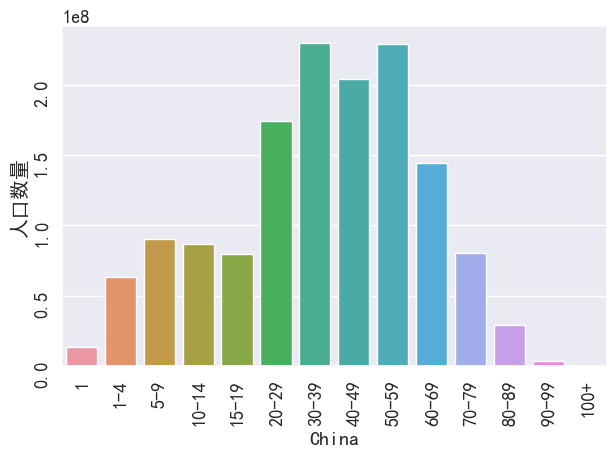

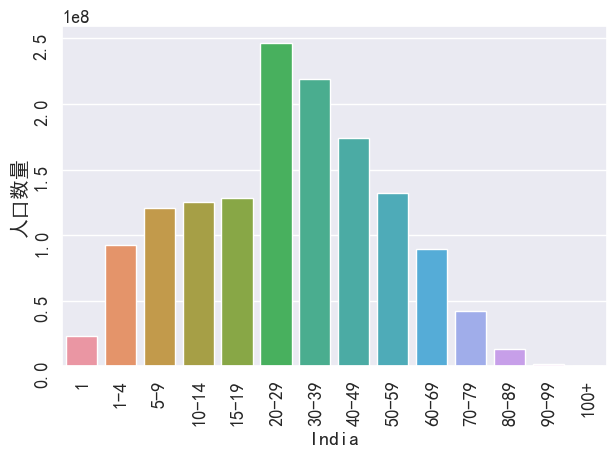

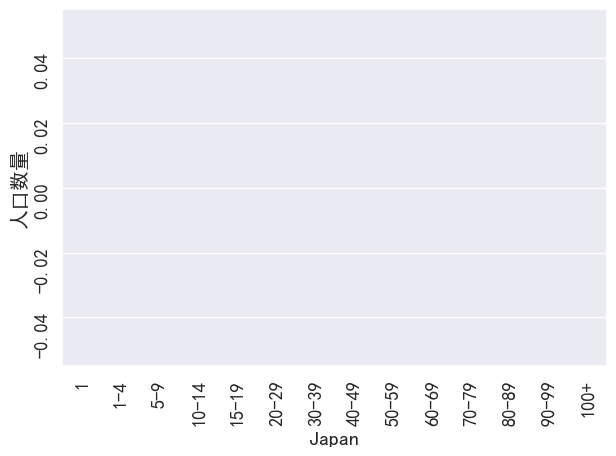

In [53]:
for idx, name in enumerate(showList):
    data = df[df['Country name'] == name]
    sns.barplot(data[data['Year'] == 2021].iloc[:, 3:])
    plt.tick_params(rotation=90)
    plt.ylabel('人口数量')
    plt.xlabel(name)
    plt.tight_layout()
    plt.show()
